In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import gymnasium as gym
import gym_trading_env
from gym_trading_env.environments import dynamic_feature_last_position_taken

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from RLTrade.agent import DQNAgent, XGBoostAgent
from RLTrade.utils import (
    stationary_dgp, 
    nonstationary_dgp, 
    # build_features, 
    # build_rolling_feature
    FeatureEngineering
)

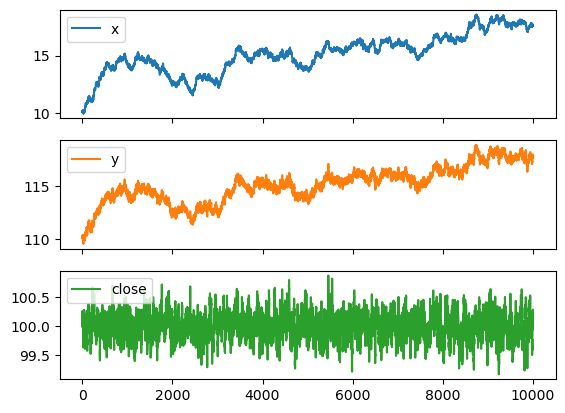

In [7]:
x, y = stationary_dgp()
spread = y - x
df = pd.DataFrame({'x': x, 'y': y, 'close': spread}) # close price of portfolio is the spread
df.plot(subplots=True)
plt.show()

In [8]:
# confirm the x, y pair is cointegrated, such that spread is stationary
x_ols = sm.add_constant(x)
ols = sm.OLS(y, x_ols).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 5.501e+05
Date:                Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                        19:48:06   Log-Likelihood:                 601.40
No. Observations:               10000   AIC:                            -1199.
Df Residuals:                    9998   BIC:                            -1184.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.0660      0.020   4897.932      0.0

In [9]:
adfuller_test = adfuller(spread)
print(f'ADF Statistic: {adfuller_test[0]}')
print(f'p-value: {adfuller_test[1]}')
print('Is the spread stationary? {}'.format('Yes' if adfuller_test[1] < 0.05 else 'No'))

ADF Statistic: -19.68813737584344
p-value: 0.0
Is the spread stationary? Yes


In [ ]:
feature_config = [
    {'type': 'rolling',
     'params': {
       'cols': ['close'],
       'window': 7,
       'mode': 'diff',
       'subtract_mean': False
     }},
]

df_train = df.copy()
fe = FeatureEngineering(df_train)
df_train = fe.build_features(feature_config)

In [22]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationary_dgp",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        dynamic_feature_functions = [],
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)

while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(position_index)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[0. 0. 0. 0. 0. 0. 0.]
Market Return :  0.06%   |   Portfolio Return : -57.94%   |   Position Changes : 6684   |   Episode Length : 10000   |   


In [23]:
# Train a DQN agent using training data from a stationary data generating process
agent = DQNAgent(n_observations=n_observations, n_actions=n_actions)
history_metrics, _ = agent.train(env, num_episodes=15) # Beware of overfitting when num_episodes is too high

Market Return :  0.06%   |   Portfolio Return : -45.27%   |   Position Changes : 5705   |   Episode Length : 10000   |   
Market Return :  0.06%   |   Portfolio Return :  2.94%   |   Position Changes : 4401   |   Episode Length : 10000   |   
Market Return :  0.06%   |   Portfolio Return :  6.01%   |   Position Changes : 4028   |   Episode Length : 10000   |   
Market Return :  0.06%   |   Portfolio Return : 28.06%   |   Position Changes : 3881   |   Episode Length : 10000   |   
Market Return :  0.06%   |   Portfolio Return : 21.52%   |   Position Changes : 3854   |   Episode Length : 10000   |   
Market Return :  0.06%   |   Portfolio Return : 28.76%   |   Position Changes : 3867   |   Episode Length : 10000   |   
Market Return :  0.06%   |   Portfolio Return : 45.04%   |   Position Changes : 3784   |   Episode Length : 10000   |   
Market Return :  0.06%   |   Portfolio Return : 43.19%   |   Position Changes : 3769   |   Episode Length : 10000   |   
Market Return :  0.06%   |   Po

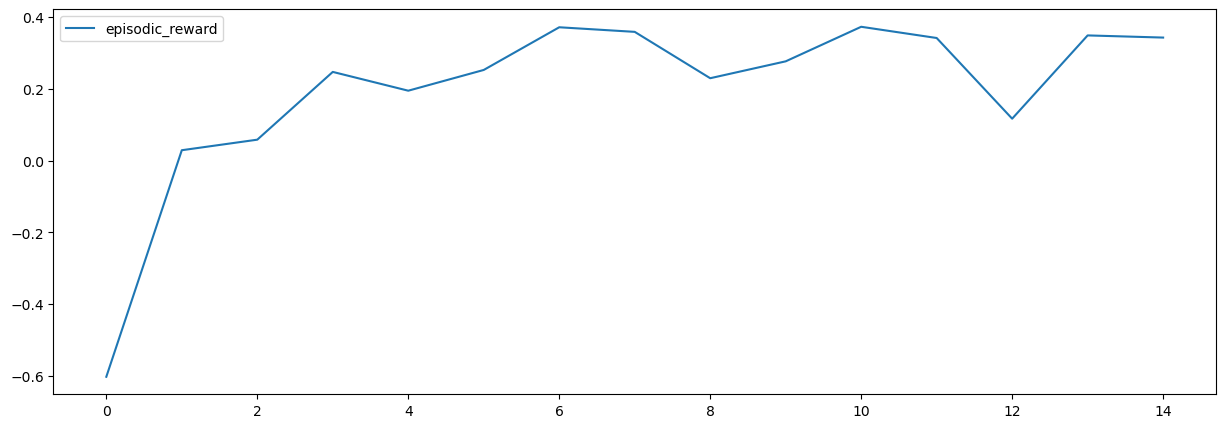

In [24]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))
plt.show()

In [29]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x, y = stationary_dgp()
    spread = y - x
    _df = pd.DataFrame({'x': x, 'y': y, 'close': spread})
    fe = FeatureEngineering(_df)
    _df = fe.build_features(feature_config)
    
    env_test = gym.make("TradingEnv",
            name= "stationary_dgp",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            dynamic_feature_functions = [],
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return :  0.24%   |   Portfolio Return : 14.58%   |   Position Changes : 1578   |   Episode Length : 10000   |   
Market Return :  0.11%   |   Portfolio Return : 14.12%   |   Position Changes : 1637   |   Episode Length : 10000   |   
Market Return :  0.14%   |   Portfolio Return : 18.04%   |   Position Changes : 1592   |   Episode Length : 10000   |   
Market Return : -0.05%   |   Portfolio Return : 28.61%   |   Position Changes : 1664   |   Episode Length : 10000   |   
Market Return : -0.17%   |   Portfolio Return : 26.58%   |   Position Changes : 1667   |   Episode Length : 10000   |   
Market Return :  0.12%   |   Portfolio Return : 21.40%   |   Position Changes : 1582   |   Episode Length : 10000   |   
Market Return :  0.14%   |   Portfolio Return : 22.48%   |   Position Changes : 1610   |   Episode Length : 10000   |   
Market Return :  0.17%   |   Portfolio Return : 47.76%   |   Position Changes : 1674   |   Episode Length : 10000   |   
Market Return :  0.07%   |   Por

In [30]:
# from gym_trading_env.renderer import Renderer
# renderer = Renderer(render_logs_dir="render_logs")
# renderer.run()

In [31]:
# build features
df_train = df.copy()

feature_config = [
    {'type': 'rolling',
     'params': {
       'cols': ['close'],
       'window': 7,
       'mode': 'diff',
       'subtract_mean': False
     }},
]

fe = FeatureEngineering(df_train)
fe.build_features(feature_config)
df_train = fe.df.copy()
df_train

,x,y,close,feature_close_lag_0,feature_close_lag_1,feature_close_lag_2,feature_close_lag_3,feature_close_lag_4,feature_close_lag_5,feature_close_lag_6
0,10.067196,110.117457,100.050262,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,10.077363,110.101089,100.023726,-0.026536,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,10.063840,110.133674,100.069834,0.046108,-0.026536,0.000000,0.000000,0.000000,0.000000,0.000000
3,10.063989,110.133219,100.069231,-0.000604,0.046108,-0.026536,0.000000,0.000000,0.000000,0.000000
4,10.053091,110.093863,100.040771,-0.028459,-0.000604,0.046108,-0.026536,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
9995,17.670097,117.955047,100.284949,0.047706,0.059927,0.100159,0.098747,0.035997,-0.041153,0.013040
9996,17.695837,117.690493,99.994656,-0.290293,0.047706,0.059927,0.100159,0.098747,0.035997,-0.041153
9997,17.669040,117.811124,100.142084,0.147427,-0.290293,0.047706,0.059927,0.100159,0.098747,0.035997
9998,17.613225,117.890174,100.276949,0.134865,0.147427,-0.290293,0.047706,0.059927,0.100159,0.098747


In [32]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationary_dgp",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # dynamic_feature_functions = [dynamic_feature_last_position_taken],
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(0)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[ 0.  0.  0.  0.  0.  0.  0. -1. -1.]
Market Return :  0.06%   |   Portfolio Return : -0.06%   |   Position Changes : 0   |   Episode Length : 10000   |   


In [33]:
agent = XGBoostAgent(n_observations, n_actions)
history_metrics, _ = agent.train(env, num_episodes=20, replay_every=2)

Market Return :  0.06%   |   Portfolio Return : -60.60%   |   Position Changes : 6548   |   Episode Length : 10000   |   
Market Return :  0.06%   |   Portfolio Return : -59.63%   |   Position Changes : 6737   |   Episode Length : 10000   |   
Market Return :  0.06%   |   Portfolio Return : -36.94%   |   Position Changes : 6444   |   Episode Length : 10000   |   
Market Return :  0.06%   |   Portfolio Return : -29.70%   |   Position Changes : 6402   |   Episode Length : 10000   |   
Market Return :  0.06%   |   Portfolio Return : 37.20%   |   Position Changes : 5548   |   Episode Length : 10000   |   
Market Return :  0.06%   |   Portfolio Return : 41.68%   |   Position Changes : 5649   |   Episode Length : 10000   |   
Market Return :  0.06%   |   Portfolio Return : 146.68%   |   Position Changes : 4267   |   Episode Length : 10000   |   
Market Return :  0.06%   |   Portfolio Return : 115.34%   |   Position Changes : 4393   |   Episode Length : 10000   |   
Market Return :  0.06%   |

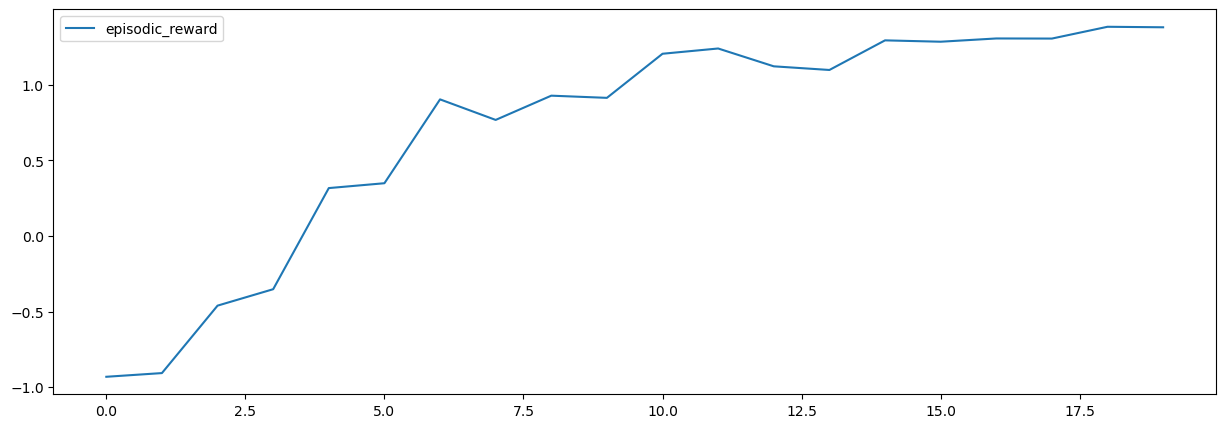

In [34]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))
plt.show()

In [35]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x, y = stationary_dgp()
    spread = y - x
    _df = pd.DataFrame({'x': x, 'y': y, 'close': spread})
    fe = FeatureEngineering(_df)
    fe.build_features(feature_config)
    _df = fe.df.copy()

    env_test = gym.make("TradingEnv",
            name= "stationary_dgp",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
            # dynamic_feature_functions = [dynamic_feature_last_position_taken],
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return :  0.14%   |   Portfolio Return : 86.10%   |   Position Changes : 882   |   Episode Length : 10000   |   
Market Return : -0.08%   |   Portfolio Return : 112.59%   |   Position Changes : 903   |   Episode Length : 10000   |   
Market Return : -0.34%   |   Portfolio Return : 116.38%   |   Position Changes : 890   |   Episode Length : 10000   |   
Market Return :  0.26%   |   Portfolio Return : 112.08%   |   Position Changes : 923   |   Episode Length : 10000   |   
Market Return :  0.11%   |   Portfolio Return : 131.68%   |   Position Changes : 886   |   Episode Length : 10000   |   
Market Return : -0.01%   |   Portfolio Return : 122.30%   |   Position Changes : 911   |   Episode Length : 10000   |   
Market Return : -0.19%   |   Portfolio Return : 87.12%   |   Position Changes : 886   |   Episode Length : 10000   |   
Market Return : -0.14%   |   Portfolio Return : 134.27%   |   Position Changes : 913   |   Episode Length : 10000   |   
Market Return :  0.09%   |   Portf